In [1]:
# import pulp
import pandas as pd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/input_data.csv')
df

,hour,scenario_1,scenario_2,scenario_3,scenario_4,scenario_5,scenario_6,scenario_7,scenario_8,scenario_9,scenario_10,scenario_11,scenario_12,scenario_13,price
0,1,9.7879,11.5034,11.9791,14.1908,12.8853,15.5571,6.6945,2.5541,1.2603,1.0340,1.1279,1.1258,1.1785,88.96
1,2,9.8956,11.5903,12.0019,14.2250,12.7664,15.4913,7.0044,2.7490,1.2407,1.2346,1.2413,1.3511,1.1126,83.82
2,3,9.9362,11.6674,12.0415,14.2240,12.6339,15.3941,7.2759,2.9433,1.3617,1.5136,1.4085,1.6377,1.0718,83.00
3,4,9.9593,11.6214,12.0927,14.1792,12.4775,15.2231,7.5040,3.1699,1.5604,1.8890,1.6405,1.9333,1.0590,82.56
4,5,9.9773,11.4704,12.2061,14.1143,12.3181,14.9783,7.7236,3.4366,1.7483,2.2889,1.8440,2.1095,1.0803,82.82
5,6,9.9489,11.3350,12.3628,14.0383,12.1739,14.7051,7.9474,3.7242,1.9014,2.6829,2.1898,2.2430,1.2720,86.01
6,7,9.8652,11.2037,12.4836,13.9507,12.0989,14.4480,8.1965,3.9596,2.1412,3.1163,2.6347,2.7605,1.8364,103.21
7,8,9.7456,11.0763,12.5472,13.8463,12.0805,14.1878,8.3819,4.1212,2.4865,3.6073,3.1369,4.0025,2.7914,133.09
8,9,9.6005,10.9297,12.5222,13.6538,12.0420,13.8353,8.4435,4.1724,2.7866,4.1530,3.7785,5.6745,3.8089,113.73
9,10,9.4068,10.7313,12.4188,13.3981,11.9034,13.3404,8.4642,4.0961,2.8743,4.4477,4.2939,6.5391,4.5243,70.89


In [3]:
# 2. Model Initialization
model = pyo.ConcreteModel(name="Battery_Wind_Optimization")

# Sets
model.T = pyo.RangeSet(1, 24)
scenarios = [f'scenario_{i}' for i in range(1, 14)]

# Parameters
cap_max = 16.0       # MWh
p_ch_max = 5.0       # MW
p_dis_max = 4.0      # MW
eff_ch = 0.8         # 80%
max_cycles = 2
prices = df.set_index('hour')['price'].to_dict()

# 3. Variables
model.p_ch = pyo.Var(model.T, domain=pyo.NonNegativeReals, bounds=(0, p_ch_max))    # charging rate
model.p_dis = pyo.Var(model.T, domain=pyo.NonNegativeReals, bounds=(0, p_dis_max))  # discharging rate
model.soc = pyo.Var(model.T, domain=pyo.NonNegativeReals, bounds=(0, cap_max))      # State of Charge (MWh)
model.u = pyo.Var(model.T, domain=pyo.Binary) # Charging state indicator            # state of charging

# 4. Objective Function
# Expected Wind Revenue (Constant in optimization)
avg_wind_gen = df[scenarios].mean(axis=1)
expected_wind_rev = sum(avg_wind_gen[t-1] * prices[t] for t in model.T)

def obj_rule(m):
    # Battery revenue = Sold - Bought
    battery_rev = sum((m.p_dis[t] - m.p_ch[t]) * prices[t] for t in m.T)
    return expected_wind_rev + battery_rev # no netting means that wind revenue just adds to battery revenue

# define the objective of the problem, i.e., maximise
model.obj = pyo.Objective(rule=obj_rule, sense=pyo.maximize)

# 5. Constraints
# State of Charge Balance
def soc_balance_rule(m, t):
    if t == 1:
        return m.soc[t] == (m.p_ch[t] * eff_ch) - m.p_dis[t]
    return m.soc[t] == m.soc[t-1] + (m.p_ch[t] * eff_ch) - m.p_dis[t]
model.soc_cons = pyo.Constraint(model.T, rule=soc_balance_rule)

# Boundary Conditions for the beginning and the end of the day
model.initial_soc_cons = pyo.Constraint(expr= model.soc[1] == 0)
model.final_soc_cons = pyo.Constraint(expr= model.soc[24] == 0)

# Power Limits & Exclusive State (Binary logic)
def ch_limit_rule(m, t):
    return m.p_ch[t] <= p_ch_max * m.u[t]
model.ch_limit = pyo.Constraint(model.T, rule=ch_limit_rule)

def dis_limit_rule(m, t):
    return m.p_dis[t] <= p_dis_max * (1 - m.u[t])
model.dis_limit = pyo.Constraint(model.T, rule=dis_limit_rule)

# Cycle Constraint (2 full cycles = 32 MWh into the battery)
# 
model.cycle_limit = pyo.Constraint(expr= sum(model.p_ch[t] * eff_ch for t in model.T) <= max_cycles * cap_max)

# 6. Solve
solver = pyo.SolverFactory('highs')
solver.solve(model)

{'Problem': [{'Lower bound': 19680.01633746154, 'Upper bound': 19680.01633746154, 'Number of objectives': 1, 'Number of constraints': nan, 'Number of variables': nan, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.convergenceCriteriaSatisfied'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

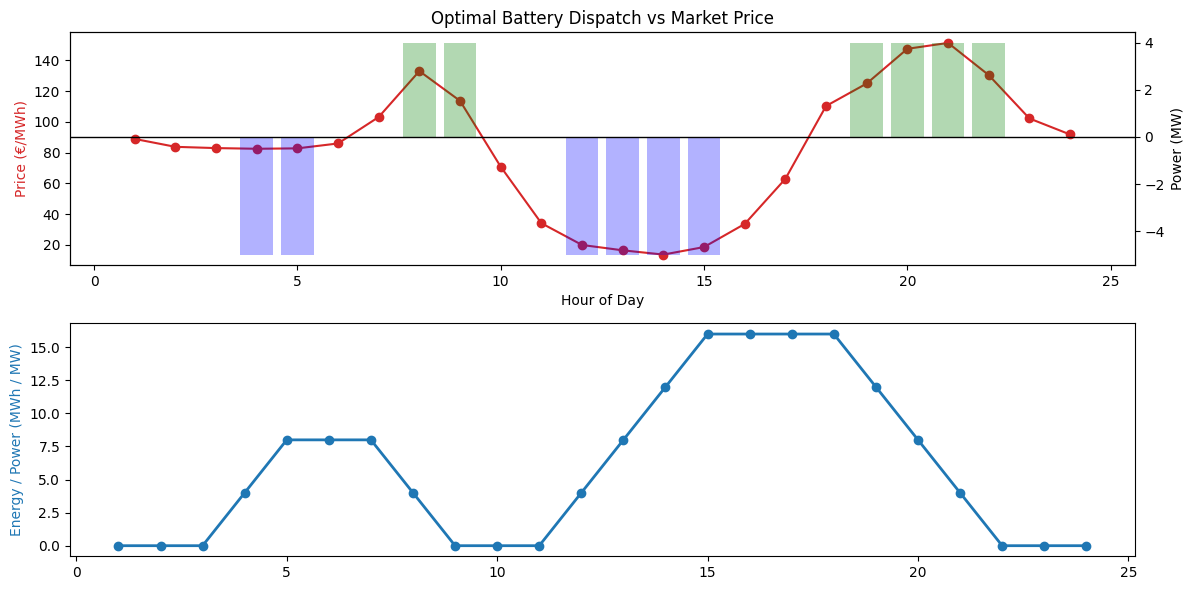

In [11]:
# Extract results for plotting
hours = list(model.T)
p_ch_res = [pyo.value(model.p_ch[t]) for t in model.T]
p_dis_res = [pyo.value(model.p_dis[t]) for t in model.T]
soc_res = [pyo.value(model.soc[t]) for t in model.T]
price_vals = [prices[t] for t in model.T]

fig, axs = plt.subplots(2, figsize=(12, 6))

ax1,ax2 = axs
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Price (€/MWh)', color='tab:red')
ax1.plot(hours, price_vals, color='tab:red', marker='o', label='Market Price')
ax1_2 = ax1.twinx()
ax1_2.set_ylabel('Power (MW)')
ax1_2.axhline(0, color='black', linewidth=1)
ax1_2.bar(hours, [-p for p in p_ch_res], color='blue', alpha=0.3, label='Charge (Power In)')
ax1_2.bar(hours, p_dis_res, color='green', alpha=0.3, label='Discharge (Power Out)')


ax2.set_ylabel('Energy / Power (MWh / MW)', color='tab:blue')
ax2.plot(hours, soc_res, color='tab:blue', marker='o', linewidth=2, label='State of Charge')

plt.title('Optimal Battery Dispatch vs Market Price')
fig.tight_layout()
plt.show()